In [1]:
from composer.utils.object_store import ObjectStoreProviderHparams
from lth_diet.data.data_diet import RandomSubset, SubsetByScore
from lth_diet.exps.train import TrainExperiment
from lth_diet.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
plt.style.use("default")
sns.set(style="whitegrid", rc={"figure.dpi": 120, "figure.figsize": (4.8, 3.6)})
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY', ).initialize_object()

In [2]:
def get_steps_accs(exp_hash, num_reps, object_store):
    steps_rt, accs_rt = [], []
    for rep in range(num_reps):
        object_store.download_object(f"exps/{exp_hash}/replicate_{rep}/main/log.txt", "temp.txt", True)
        series = pd.read_table("temp.txt", header=None)[0]
        steps_t, accs_t = [], []
        for x in series:
            match = re.search('\[EPOCH\]\[step=(\d*)\]: { "accuracy/val": ([+-]?[0-9]*[.]?[0-9]+), \}', x)
            if match:
                steps_t.append(int(match.group(1)))
                accs_t.append(float(match.group(2)))
        steps_rt.append(steps_t)
        accs_rt.append(accs_t)
    steps_rt, accs_rt = np.array(steps_rt), np.array(accs_rt)
    return steps_rt, accs_rt

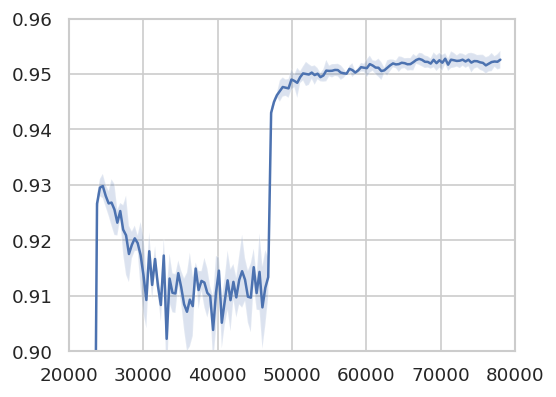

In [3]:
exp = TrainExperiment.create(f='/home/mansheej/lth_diet/configs/cifar10_resnet18.yaml', cli_args=False)
exp_hash = utils.get_hash(exp.name)
num_reps = 4
steps_rt, accs_rt = get_steps_accs(exp_hash, num_reps, object_store)
x, ys = steps_rt[0], accs_rt
plt.plot(x, ys.mean(0))
plt.fill_between(x, ys.mean(0) - ys.std(0), ys.mean(0) + ys.std(0), alpha=0.2)
plt.xlim(20000, 80000)
plt.ylim(0.9, 0.96)
plt.show()

In [4]:
exp = TrainExperiment.create(f='/home/mansheej/lth_diet/configs/cifar10_resnet18.yaml', cli_args=False)
exp_hash = utils.get_hash(exp.name)
num_reps = 4
steps_rt, accs_rt = get_steps_accs(exp_hash, num_reps, object_store)
ys_b = accs_rt[:, -1]

sizes, num_reps = [45000, 40000, 35000, 30000, 25000, 20000], 4
ys_r = []
for size in sizes:
    exp = TrainExperiment.create(f='/home/mansheej/lth_diet/configs/cifar10_resnet18.yaml', cli_args=False)
    exp.train_data.dataset_transforms = [RandomSubset(size, True, 1234)]
    exp_hash = utils.get_hash(exp.name)
    _, accs = get_steps_accs(exp_hash, num_reps, object_store)
    ys_r.append(accs[:, -1])
ys_r = np.stack(ys_r, axis=1)

sizes, num_reps = [45000, 40000, 35000, 30000, 25000, 20000], 4
ys_s = []
for size in sizes:
    exp = TrainExperiment.create(f='/home/mansheej/lth_diet/configs/cifar10_resnet18.yaml', cli_args=False)
    exp.train_data.dataset_transforms = [SubsetByScore("error_norm_cifar10_resnet18_3900ba_10reps_seed1009.npy", size, right_offset=0)]
    exp_hash = utils.get_hash(exp.name)
    _, accs = get_steps_accs(exp_hash, num_reps, object_store)
    ys_s.append(accs[:, -1])
ys_s = np.stack(ys_s, axis=1)

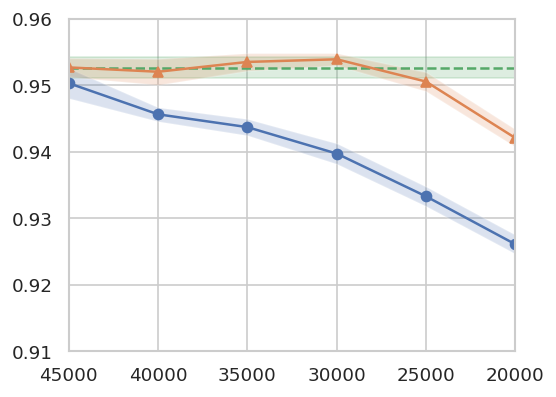

In [7]:
plt.axhline(ys_b.mean(0), ls='--', c="C2")
plt.fill_between(sizes, [ys_b.mean(0) - ys_b.std(0)]*len(sizes), [ys_b.mean(0) + ys_b.std(0)]*len(sizes), alpha=0.2, color="C2")
plt.plot(sizes, ys_r.mean(0), '-o')
plt.fill_between(sizes, ys_r.mean(0) - ys_r.std(0), ys_r.mean(0) + ys_r.std(0), alpha=0.2)
plt.plot(sizes, ys_s.mean(0), '-^')
plt.fill_between(sizes, ys_s.mean(0) - ys_s.std(0), ys_s.mean(0) + ys_s.std(0), alpha=0.2)
plt.xlim(45000, 20000)
plt.ylim(0.91, 0.96)
plt.show()